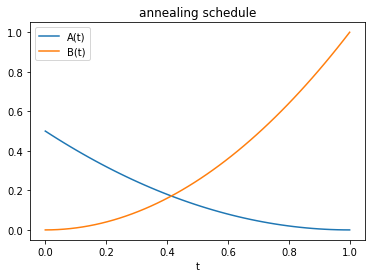

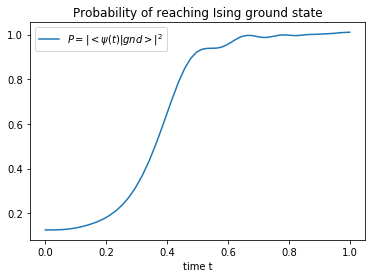

In [20]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems


n=3 # number of qubits

# parameter  (Jij is i>j , i.e., lower diagonal)
Jij=np.zeros((n,n))
hi=np.zeros((n))

Jij[:,:]=1.0
hi[:]=1.0
hi[1]=-1.0
energyscale=100.0 # overall energy scale of time-dependent hamiltonian

# time is set to be between [0,1]

# offset ci as function of t
def ci(t):
    ci=np.zeros((n))
    #ci=0.05*np.absolute(hi)
    return ci

# average  ci cj for coupling
def cij(t):
    c=ci(t)
    return np.asarray([[0.5*(c[i]+c[j]) for i in range(n)] for j in range(n)])


# pauli matrices
sigx=np.zeros((2,2))
sigz=np.zeros((2,2))
id2=np.identity(2)

sigx[0,1]=1.0
sigx[1,0]=1.0
sigz[0,0]=1.0
sigz[1,1]=-1.0


# push local operator to many body Fock space
def pushtoFock(i,local,n):
    fock=np.identity(1)
    for j in range(n):
        if (j==i):
            fock=np.kron(fock,local)            
        else:
            fock=np.kron(fock,id2)
    return fock


#print(pushtoFock(2,sigz,n))

# hamiltonian (Jij is i>j , i.e., lower diagonal)
def constructIsingH(Jij,hi,n):
    IsingH=np.zeros((2**n,2**n))
    for i in range(n):
        temp=pushtoFock(i,sigz,n)
        IsingH+=hi[i]*temp
        for j in range(i):
            IsingH+=Jij[i,j]*np.dot(temp,pushtoFock(j,sigz,n))
    return IsingH



def constructtransverseH(hxi,n):
    transverseH=np.zeros((2**n,2**n))
    for i in range(n):
        transverseH+=hxi[i]*pushtoFock(i,sigx,n)
    return transverseH

IsingH=constructIsingH(Jij,hi,n)
#print(IsingH)
transverseH=constructtransverseH(np.ones((n)),n)

#print(np.ones((n)))

# annealing schedule functions (no offset)
# t=0: A=0.5 and B=0.0
# t=1: A=0.0 and B=1.0

def A(t):
    return 0.5*((t-1.0)**2)
    
def B(t):
    return t**2

tgrid=np.linspace(0,1)


plt.plot(tgrid,A(tgrid),tgrid,B(tgrid))
plt.legend(['A(t)','B(t)'])
plt.title('annealing schedule')
plt.xlabel('t')
plt.show()



# brute force diagonalizaing transverse field hamiltonian

energy,eigv=np.linalg.eigh(transverseH)


#print('transverse')
#print('eigen envergy',energy)
#print('eigen vector')
#print(eigv)


# time-dependent offset
def offsetH(t):
    return energyscale*(-0.5*A(t)*constructtransverseH(ci(t),n)+0.5*B(t)*constructIsingH(cij(t),ci(t),n))

# annealing hamiltonian
def annealingH(t):
    H=energyscale*(-0.5*A(t)*transverseH+0.5*B(t)*IsingH) # annealing hamiltonian
    H+=offsetH(t) # offsets
    return H


# define time-dependent schrodinger equation
def tdse(t,y):
    f=-1j*np.dot(annealingH(t),y)
    return f

# initial state
xev=np.asarray([1.0/np.sqrt(2.0),1.0/np.sqrt(2.0)])
y0=xev[:]
for i in range(n-1):
    y0=np.kron(xev,y0)
y0=(1.0+0.0j)*y0 #ensure complex dtype
#print('initial state',y0)

# solve ode
sol=solve_ivp(tdse, [0.0, 1.0], y0)

#print('ode solution')
#for i in range(sol.t.size):
#    print('time',i,'=',sol.t[i])
#    print(sol.y[:,i])


# brute force diagonalization Ising hamiltonain

energy,eigv=np.linalg.eigh(IsingH)
#print('brute force Ising')
#print('eigen envergy',energy)
#print('eigen vector')
#print(eigv)

# plot probability overlap with Ising ground state
overlap=np.zeros(sol.t.size)
for i in range(sol.t.size):
    overlap[i]=np.absolute(np.dot(eigv[:,0],sol.y[:,i]))**2


plt.plot(sol.t,overlap)
plt.legend([r'$P= |<\psi (t) | gnd >|^2$'])
plt.xlabel('time t')
plt.title('Probability of reaching Ising ground state')
plt.show()
